In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error  # use this instead of root_mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [52]:
df = pd.read_csv(r"C:\Users\win-10\Downloads\train.csv\train.csv")
retail = df.copy()

In [121]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [4]:
retail.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [5]:
retail.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [6]:
retail['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [7]:
retail['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [8]:
retail.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [9]:
retail['date'].max() , retail['date'].min() 

('2017-08-15', '2013-01-01')

In [10]:
retail.shape

(3000888, 6)

In [54]:
retail = retail.drop(columns = ['id', 'onpromotion', 'family', 'store_nbr'])

In [55]:
retail

,date,sales
0,2013-01-01,0.000
1,2013-01-01,0.000
2,2013-01-01,0.000
3,2013-01-01,0.000
4,2013-01-01,0.000
...,...,...
3000883,2017-08-15,438.133
3000884,2017-08-15,154.553
3000885,2017-08-15,2419.729
3000886,2017-08-15,121.000


In [12]:
retail.loc[retail['sales'] == 0.0 ,['date']].nunique()


date    1684
dtype: int64

In [53]:
free_days = retail.loc[retail['sales'] == 0.0 ,['date','store_nbr','sales', 'store_nbr']]
free_days

,date,store_nbr,sales,store_nbr
0,2013-01-01,1,0.0,1
1,2013-01-01,1,0.0,1
2,2013-01-01,1,0.0,1
3,2013-01-01,1,0.0,1
4,2013-01-01,1,0.0,1
...,...,...,...,...
3000839,2017-08-15,8,0.0,8
3000853,2017-08-15,8,0.0,8
3000856,2017-08-15,9,0.0,9
3000859,2017-08-15,9,0.0,9


In [14]:
free_days['store_nbr'].nunique()

54

In [8]:
days_sales = retail.loc[retail['sales'] != 0.0 ,['date','store_nbr','sales']
days_sales

,date,store_nbr,sales,family
563,2013-01-01,25,2.000,BEAUTY
564,2013-01-01,25,810.000,BEVERAGES
566,2013-01-01,25,180.589,BREAD/BAKERY
568,2013-01-01,25,186.000,CLEANING
569,2013-01-01,25,143.000,DAIRY
...,...,...,...,...
3000883,2017-08-15,9,438.133,POULTRY
3000884,2017-08-15,9,154.553,PREPARED FOODS
3000885,2017-08-15,9,2419.729,PRODUCE
3000886,2017-08-15,9,121.000,SCHOOL AND OFFICE SUPPLIES


In [16]:
days_sales['sales'].mean(),days_sales['sales'].max(), days_sales['sales'].min() 

(np.float64(520.7424693892632), np.float64(124717.0), np.float64(0.122))

In [9]:
pd.options.display.max_rows = 999
most_sails_per_family = days_sales.loc[days_sales['sales']>= 389, ['family','sales','date']].sort_values( by = 'sales',ascending = False)
most_sails_per_family

,family,sales,date
2163723,GROCERY I,124717.000,2016-05-02
2445984,MEATS,89576.360,2016-10-07
2144154,GROCERY I,87438.516,2016-04-21
2139699,GROCERY I,76090.000,2016-04-18
2153031,GROCERY I,63434.000,2016-04-26
...,...,...,...
1278659,DAIRY,389.000,2014-12-20
2018272,PERSONAL CARE,389.000,2016-02-10
2592832,"LIQUOR,WINE,BEER",389.000,2016-12-30
1621067,DAIRY,389.000,2015-07-01


In [10]:
most_per_sum_price = most_sails_per_family.groupby('family')['sales'].sum().round(0).sort_values( ascending = False)
most_per_sum_price

family
GROCERY I                     343461519.0
BEVERAGES                     216318056.0
PRODUCE                       120765880.0
CLEANING                       96331377.0
DAIRY                          58198170.0
BREAD/BAKERY                   34109603.0
POULTRY                        22036447.0
MEATS                          20748911.0
PERSONAL CARE                  10807967.0
DELI                           10390995.0
HOME CARE                       6908032.0
FROZEN FOODS                    5603237.0
EGGS                            4431867.0
LIQUOR,WINE,BEER                1585740.0
PREPARED FOODS                  1322331.0
HOME AND KITCHEN I                54102.0
SCHOOL AND OFFICE SUPPLIES        40861.0
HOME AND KITCHEN II               39256.0
GROCERY II                        11484.0
CELEBRATION                        7017.0
LINGERIE                           1827.0
LAWN AND GARDEN                    1627.0
Name: sales, dtype: float64

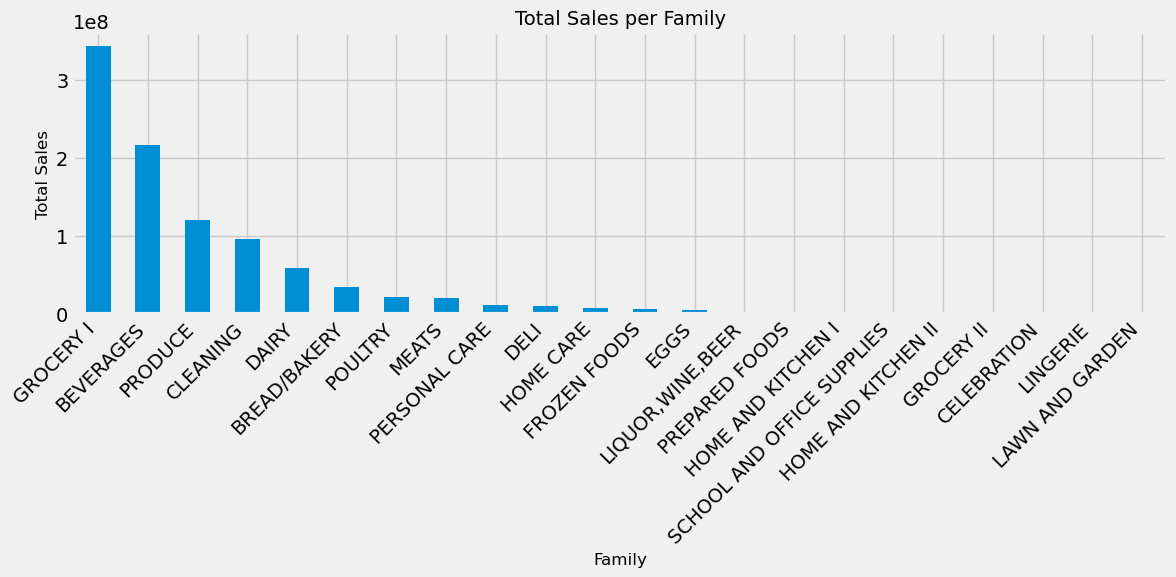

In [11]:
import matplotlib.pyplot as plt

# Your grouped + summed data
most_per_sum_price = (
    most_sails_per_family
    .groupby('family')['sales']
    .sum()
    .round(0)
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(12,6))
most_per_sum_price.plot(kind='bar')

plt.title("Total Sales per Family", fontsize=14)
plt.xlabel("Family", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [20]:
most_per_count_sale = most_sails_per_family['family'].value_counts()
most_per_count_sale

family
GROCERY I                     83597
BEVERAGES                     81480
CLEANING                      79834
DAIRY                         56623
BREAD/BAKERY                  46701
PRODUCE                       45693
MEATS                         27679
POULTRY                       26524
PERSONAL CARE                 17484
DELI                          17120
HOME CARE                     11764
EGGS                           7893
FROZEN FOODS                   6673
PREPARED FOODS                 2730
LIQUOR,WINE,BEER               2699
HOME AND KITCHEN I               82
SCHOOL AND OFFICE SUPPLIES       74
HOME AND KITCHEN II              70
GROCERY II                       10
CELEBRATION                       9
LAWN AND GARDEN                   3
LINGERIE                          2
Name: count, dtype: int64

In [21]:
days_sales['sales'].describe().round(2)

count    2061758.00
mean         520.74
std         1297.19
min            0.12
25%            9.00
50%           78.46
75%          388.00
max       124717.00
Name: sales, dtype: float64

In [22]:
days_sales.loc[days_sales['sales'] >= 20000, :].info()

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 79674 to 2921997
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       106 non-null    object 
 1   store_nbr  106 non-null    int64  
 2   sales      106 non-null    float64
 3   family     106 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 4.1+ KB


In [56]:
data = retail.set_index('date')
data.index = pd.to_datetime(data.index)

In [57]:
data.index 

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=3000888, freq=None)

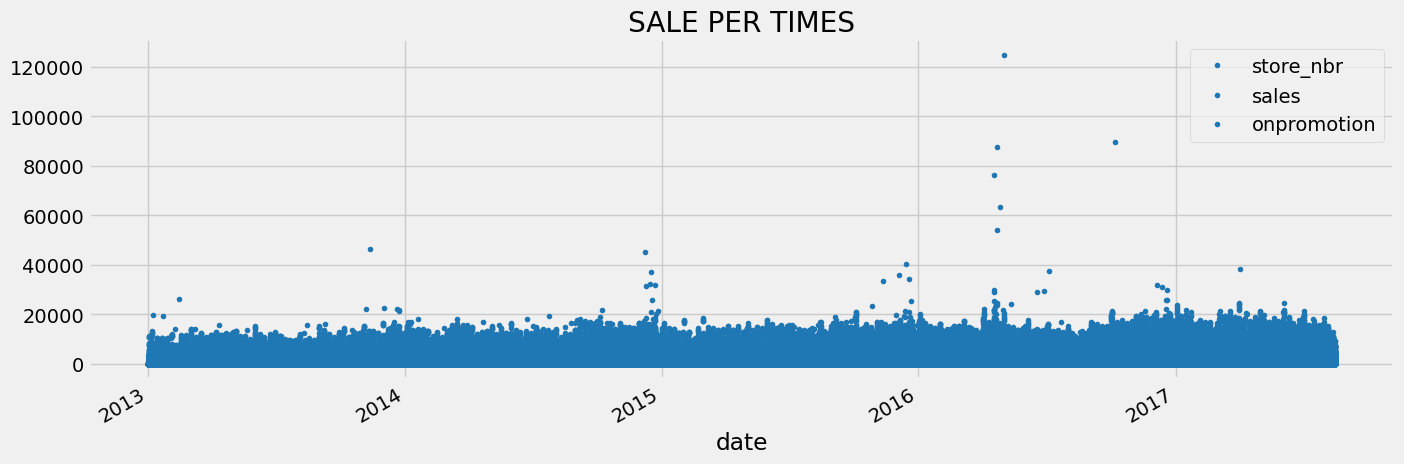

In [24]:
 
data.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='SALE PER TIMES')
plt.show()

<Axes: ylabel='Frequency'>

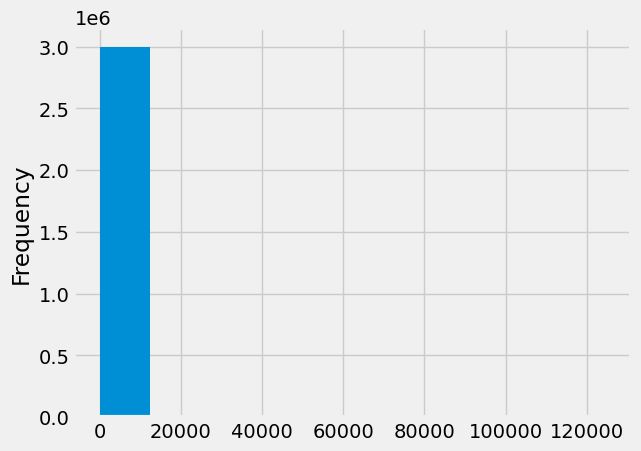

In [26]:
data['sales'].plot(kind='hist', bins=10)

<Axes: title={'center': 'Outliers'}, xlabel='date'>

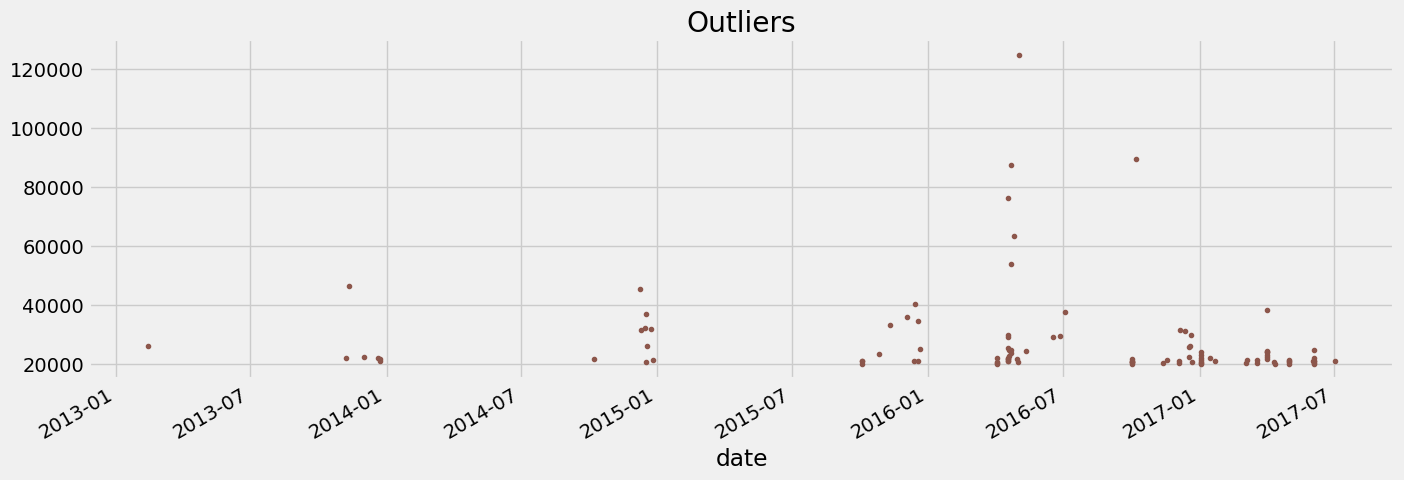

In [27]:
data.query('sales > 20000'  )['sales'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

<Axes: title={'center': 'Are Desired'}, xlabel='date'>

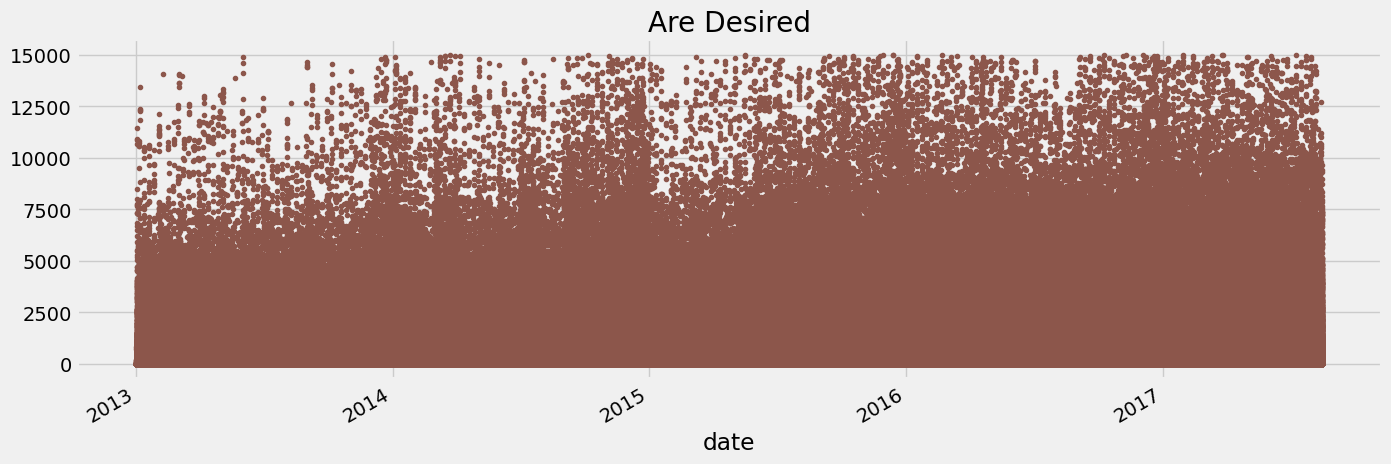

In [28]:
data.query('sales < 15000' )['sales'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Are Desired')

In [58]:
finall= data.query('sales < 15000').copy()

In [59]:
print(f"Total rows: {len(finall)}")


Total rows: 2999994


 ## Train / Test Split

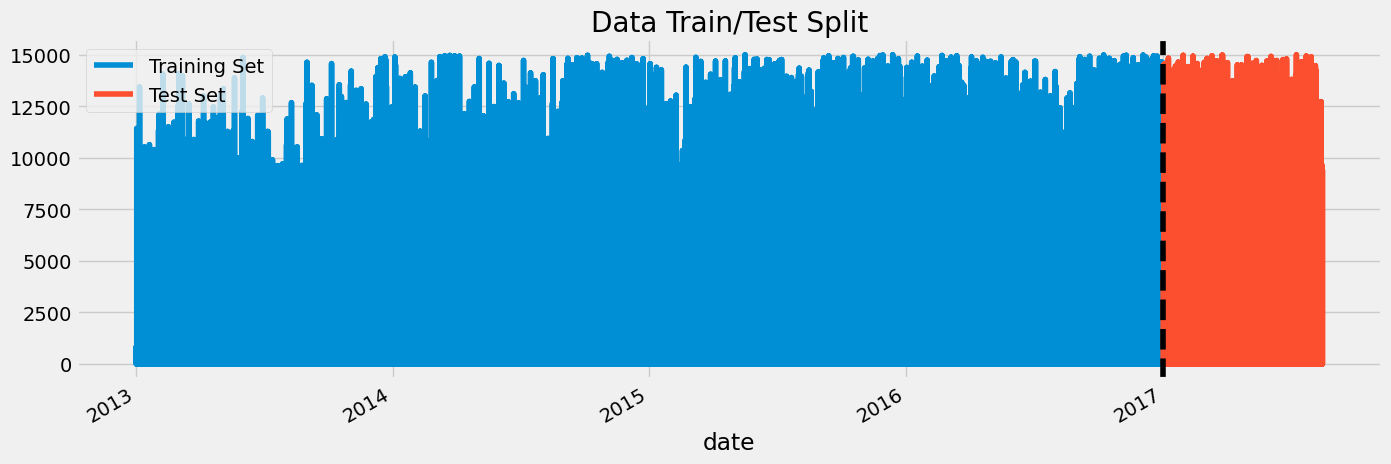

In [60]:
train = finall.loc[finall.index < '2017-01-01']
test = finall.loc[finall.index >= '2017-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(pd.to_datetime('2017-01-01'), color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


## Time Series Cross Validation

In [61]:
daily_sales = train_.groupby('date')['sales'].sum().sort_index()
daily_sales

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64

In [62]:
from sklearn.model_selection import TimeSeriesSplit


mask = (daily_sales.index >= "2017-01-01") & (daily_sales.index <= "2017-08-15")
test_size = mask.sum()  # now this counts **daily aggregated rows**, not original duplicates

tss = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=1)


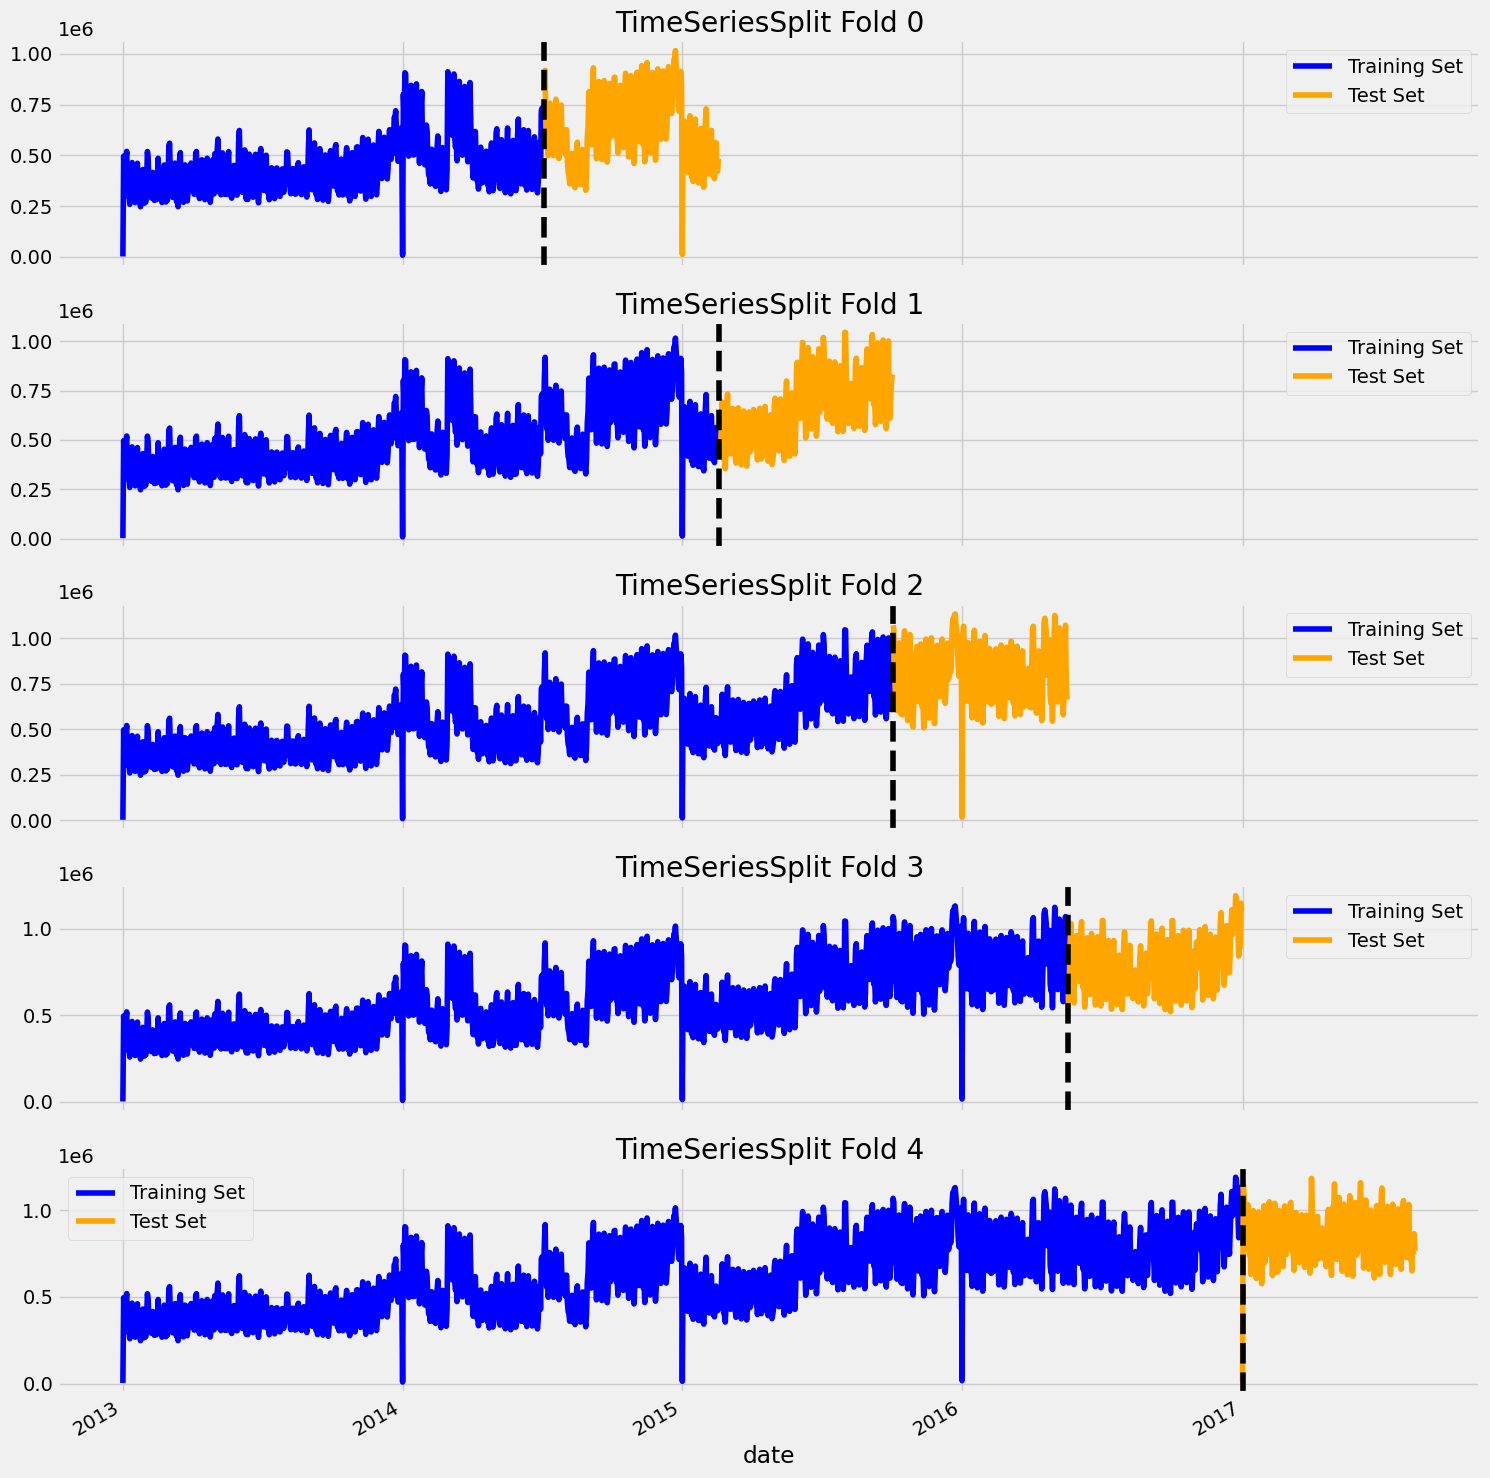

In [63]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss.split(daily_sales)):
    train_fold = daily_sales.iloc[train_idx]
    test_fold = daily_sales.iloc[val_idx]
    
    train_fold.plot(ax=axs[fold], label='Training Set', color='blue')
    test_fold.plot(ax=axs[fold], label='Test Set', color='orange')
    
    axs[fold].axvline(test_fold.index.min(), color='black', ls='--')
    axs[fold].legend()
    axs[fold].set_title(f'TimeSeriesSplit Fold {fold}')

plt.tight_layout()
plt.show()


In [64]:
def create_features(train_):
    """
    Create time series features based on time series index.
    """
    train_ = train_.copy()
    train_['dayofweek'] = train_.index.dayofweek
    train_['quarter'] = train_.index.quarter
    train_['month'] = train_.index.month
    train_['year'] = train_.index.year
    train_['dayofyear'] = train_.index.dayofyear
    train_['dayofmonth'] = train_.index.day
    train_['weekofyear'] = train_.index.isocalendar().week
    return train_

train_ = create_features(train_)

## Lag Features

In [78]:
def add_lags(train_):
    target_map = train_['sales'].to_dict()
    train_['lag1'] = (train_.index - pd.Timedelta('364 days')).map(target_map)
    return train_



In [79]:
train_ = add_lags(train_)

In [72]:
train_ = train_.drop(columns = ['store_nbr', 'family',  'onpromotion', 
       'weekofyear'
       ])

In [75]:
train_ = train_.drop(columns = ['lag_1', 'isFuture', 'lag1'
       ])

In [80]:
train_.columns

Index(['sales', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'lag1'],
      dtype='object')

In [81]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2999994 entries, 2013-01-01 to 2017-08-15
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   sales       float64
 1   dayofweek   int32  
 2   quarter     int32  
 3   month       int32  
 4   year        int32  
 5   dayofyear   int32  
 6   dayofmonth  int32  
 7   lag1        float64
dtypes: float64(2), int32(6)
memory usage: 137.3 MB


In [76]:
stores = pd.read_csv(r"C:\Users\win-10\Downloads\stores.csv")
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [50]:
oil = pd.read_csv(r"C:\Users\win-10\Downloads\oil.csv")
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [72]:
mean_value = oil['dcoilwtico'].mean().round(2)



In [74]:
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(oil['dcoilwtico'].mean())


In [75]:
oil.isna().sum()

date          0
dcoilwtico    0
dtype: int64

In [32]:
import warnings
warnings.filterwarnings("ignore")

## Train Using Cross Validation

In [82]:
import xgboost as xgb

tss = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=1)

train_ = train_.sort_index()


fold = 0 
preds = []
scores = []
for train_idx, val_idx in tss.split(train_):
    train = train_.iloc[train_idx]
    test = train_.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = [ 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'lag1']
    TARGET = 'sales'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squaredlogerror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmsle:3.68226	validation_1-rmsle:4.01190
[100]	validation_0-rmsle:3.25232	validation_1-rmsle:3.49461
[200]	validation_0-rmsle:2.95613	validation_1-rmsle:3.10467
[300]	validation_0-rmsle:2.78270	validation_1-rmsle:2.85256
[400]	validation_0-rmsle:2.69520	validation_1-rmsle:2.71754
[500]	validation_0-rmsle:2.65738	validation_1-rmsle:2.65924
[600]	validation_0-rmsle:2.64223	validation_1-rmsle:2.63383
[700]	validation_0-rmsle:2.63548	validation_1-rmsle:2.62541
[800]	validation_0-rmsle:2.63233	validation_1-rmsle:2.62275
[900]	validation_0-rmsle:2.63106	validation_1-rmsle:2.62252
[907]	validation_0-rmsle:2.63101	validation_1-rmsle:2.62255
[0]	validation_0-rmsle:3.68229	validation_1-rmsle:3.85781
[100]	validation_0-rmsle:3.25233	validation_1-rmsle:3.32705
[200]	validation_0-rmsle:2.95614	validation_1-rmsle:2.92541
[300]	validation_0-rmsle:2.78271	validation_1-rmsle:2.66605
[400]	validation_0-rmsle:2.69520	validation_1-rmsle:2.52884
[500]	validation_0-rmsle:2.65738	validation_

In [83]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1278.6978
Fold scores:[np.float64(1261.8961099569005), np.float64(853.6704593962669), np.float64(1551.9682669167316), np.float64(1577.3500872120937), np.float64(1148.6042389905404)]


## Train on All Data

In [85]:
# Retrain on all data
train_ = create_features(train_)

FEATURES = [ 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'lag1']
TARGET = 'sales'

X_all = train_[FEATURES]
y_all = train_[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:1109.64864
[100]	validation_0-rmse:1056.74290
[200]	validation_0-rmse:1048.98304
[300]	validation_0-rmse:1047.65936
[400]	validation_0-rmse:1047.30162
[499]	validation_0-rmse:1047.16699


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [86]:
train_.index.max() 

Timestamp('2017-08-15 00:00:00')

In [87]:
# Define forecast horizon: 6 weeks ahead, daily frequency
forecast_horizon = 138  # days

# Get the last date in your training data
last_date = train_.index.max()

# Create future dates starting the day after last training date
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                             periods=forecast_horizon, 
                             freq='D')

# Create future dataframe
future_df = pd.DataFrame(index=future_dates)
future_df['isFuture'] = True

# Mark historical data
train_ = train_.copy()
train_['isFuture'] = False

# Combine
combined_df = pd.concat([train_, future_df])

# Add features
combined_df = create_features(combined_df)

# Add lags
combined_df = add_lags(combined_df)


In [88]:
future_w_features = combined_df.query('isFuture').copy()

In [89]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

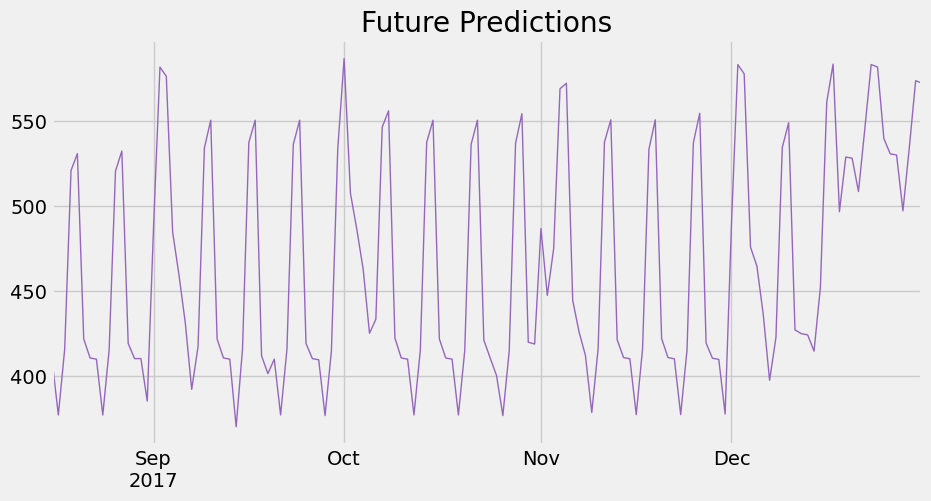

In [90]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()